In [1]:
from sodapy import Socrata
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
path = "data/311_Cases.csv"

In [3]:
df = pd.read_csv(path)

In [4]:
ssc_df = df[df['Category']=='Street and Sidewalk Cleaning'].copy()

In [5]:
ssc_df['Opened'] = pd.to_datetime(ssc_df['Opened'])
ssc_df['hour'] = ssc_df['Opened'].dt.hour
ssc_df['minute'] = ssc_df['Opened'].dt.minute
ssc_df['day'] = ssc_df['Opened'].dt.day
ssc_df['year'] = ssc_df['Opened'].dt.year
ssc_df['Month'] = ssc_df['Opened'].dt.month

In [6]:
# Should read this to CSV so I don't have to do it again

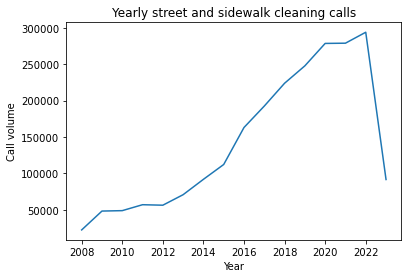

In [7]:
ssc_df['year'].value_counts().sort_index().plot()
plt.title("Yearly street and sidewalk cleaning calls")
plt.xlabel("Year")
plt.ylabel("Call volume")
plt.show()

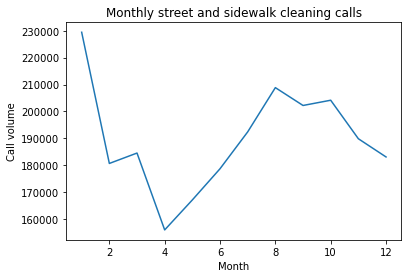

In [8]:
ssc_df['Month'].value_counts().sort_index().plot()
plt.title("Monthly street and sidewalk cleaning calls")
plt.xlabel("Month")
plt.ylabel("Call volume")
plt.show()

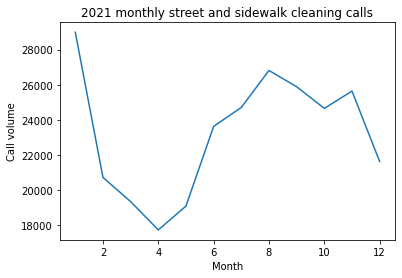

In [9]:
df_2021 = ssc_df[ssc_df['year']==2021]
df_2021['Month'].value_counts().sort_index().plot()
plt.title("2021 monthly street and sidewalk cleaning calls")
plt.xlabel("Month")
plt.ylabel("Call volume")
plt.show()

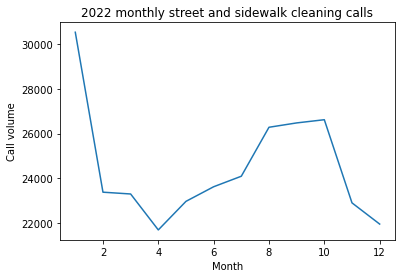

In [10]:
df_2022 = ssc_df[ssc_df['year']==2022]
df_2022['Month'].value_counts().sort_index().plot()
plt.title("2022 monthly street and sidewalk cleaning calls")
plt.xlabel("Month")
plt.ylabel("Call volume")
plt.show()

## ARIMA

In [11]:
def hour_rounder(t):
    # Rounds to nearest hour by adding a timedelta hour if minute >= 30
    return (t.replace(second=0, microsecond=0, minute=0, hour=t.hour)
               +timedelta(hours=t.minute//30))

In [12]:
ssc_df['RoundTime'] = ssc_df['Opened'].apply(hour_rounder)

In [13]:
hourly_count = ssc_df.groupby('RoundTime')['CaseID'].count()

In [14]:
hourly_count

RoundTime
2008-07-01 00:00:00     2
2008-07-01 03:00:00     1
2008-07-01 05:00:00     3
2008-07-01 06:00:00     7
2008-07-01 07:00:00     5
                       ..
2023-04-04 21:00:00    28
2023-04-04 22:00:00    15
2023-04-04 23:00:00     7
2023-04-05 00:00:00    11
2023-04-05 01:00:00    10
Name: CaseID, Length: 112319, dtype: int64

In [15]:
first_date = np.min(hourly_count.index)
last_date = np.max(hourly_count.index)
# This works for hour
# for i in range(24):
#     print("0"+str(i)+":00:00")

# for i in range(10):
#     print(hourly_count.index[0])


curr_hour = hourly_count.index[0].to_pydatetime()
all_hours = []
i = 0
while (curr_hour + timedelta(hours=i)) != (last_date.to_pydatetime() + timedelta(hours=1)):
#     if curr_hour == last_date.to_pydatetime():
#         print("Finished")
#         break
    all_hours.append(curr_hour + timedelta(hours=i))
    i+=1
    if i % 1000 ==0:
        print(i)
    if i>130000:
        break
    if curr_hour == last_date.to_pydatetime():
        print("Finished")
        break

# print(all_hours)



# for i in range(len(hourly_count.index)):    
#     print(hourly_count.index[0].to_pydatetime() + timedelta(hours=i))
#     all_hours.append()
#     pass

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000


In [16]:
all_hours = pd.DataFrame(np.array(all_hours))
all_hours.columns=['Hours']

In [17]:
# all_hours
full_hourly_count = pd.merge(all_hours, hourly_count, left_on='Hours', right_on=['RoundTime'], how='outer').fillna(0)
# full_hourly_count = full_hourly_count.set_index('Hours')

In [18]:
full_hourly_count

,Hours,CaseID
0,2008-07-01 00:00:00,2.0
1,2008-07-01 01:00:00,0.0
2,2008-07-01 02:00:00,0.0
3,2008-07-01 03:00:00,1.0
4,2008-07-01 04:00:00,0.0
...,...,...
129381,2023-04-04 21:00:00,28.0
129382,2023-04-04 22:00:00,15.0
129383,2023-04-04 23:00:00,7.0
129384,2023-04-05 00:00:00,11.0


In [19]:
print(full_hourly_count['Hours'][0])
# full_hourly_count['Year'] = 
full_hourly_count['Hours'] = pd.to_datetime(full_hourly_count['Hours'])
full_hourly_count['Year'] = full_hourly_count['Hours'].dt.year
full_hourly_count['Month'] = full_hourly_count['Hours'].dt.month
full_hourly_count['Day'] = full_hourly_count['Hours'].dt.day
full_hourly_count['Hour'] = full_hourly_count['Hours'].dt.hour

2008-07-01 00:00:00


In [20]:
full_hourly_count['CaseID']

0          2.0
1          0.0
2          0.0
3          1.0
4          0.0
          ... 
129381    28.0
129382    15.0
129383     7.0
129384    11.0
129385    10.0
Name: CaseID, Length: 129386, dtype: float64

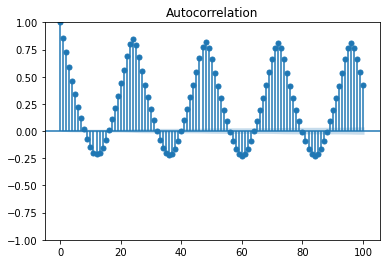

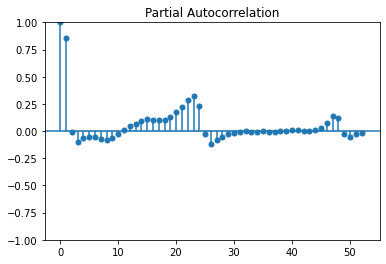

In [21]:
plot_acf(full_hourly_count['CaseID'].values.astype(float), lags=100, alpha=0.05)
plot_pacf(full_hourly_count['CaseID'].values.astype(float), method='ywm')
plt.show();

In [22]:
# Implement train test split here - probably remove this
X = full_hourly_count['CaseID'].values
# Doing an 80/20 split
split = int(len(X) * 0.80)
train, test = X[:split], X[split:]
train_dates, test_dates = full_hourly_count.index[:split], full_hourly_count.index[split:]

### 2021 predict 2022 ARIMA (24,1,0)

In [23]:
data_2021 = full_hourly_count[full_hourly_count['Year']==2021]
data_2021

data_2022 = full_hourly_count[full_hourly_count['Year']==2022]
data_2022

,Hours,CaseID,Year,Month,Day,Hour
118368,2022-01-01 00:00:00,10.0,2022,1,1,0
118369,2022-01-01 01:00:00,6.0,2022,1,1,1
118370,2022-01-01 02:00:00,5.0,2022,1,1,2
118371,2022-01-01 03:00:00,1.0,2022,1,1,3
118372,2022-01-01 04:00:00,11.0,2022,1,1,4
...,...,...,...,...,...,...
127123,2022-12-31 19:00:00,6.0,2022,12,31,19
127124,2022-12-31 20:00:00,5.0,2022,12,31,20
127125,2022-12-31 21:00:00,5.0,2022,12,31,21
127126,2022-12-31 22:00:00,11.0,2022,12,31,22


In [24]:
# model=ARIMA()
# params = {}
# cv_model = GridSearchCV(model, param_grid=params, scoring='accuracy', refit=True, return_train_score=True)
# cv_model.fit(X_train, y_train)
# model = cv_model.best_estimator_
# model.fit(X_train, y_train)

# GridSearchCV()


model = auto_arima(data_2021['CaseID'].values, start_p=1, start_q=1,
                           max_p=26, max_q=2, m=1,
                           seasonal=True,
                           d=0, trace=True,
                           error_action='warn',  
                           suppress_warnings=True, 
                           stepwise=True)
print(model.aic())

model.fit(data_2021['CaseID'].values)

prediction1 = model.predict(n_periods=len(data_2021['CaseID'].values))
prediction2 = model.predict(n_periods=len(data_2022['CaseID'].values))

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=77446.478, Time=4.87 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=85891.031, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=77509.050, Time=0.34 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=80564.173, Time=1.45 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=91761.121, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=76925.478, Time=4.73 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=77438.870, Time=0.53 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=76903.844, Time=6.09 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=77420.684, Time=0.65 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=76813.261, Time=6.58 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=77382.686, Time=0.89 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=76722.863, Time=8.18 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=77313.705, Time=1.08 sec
 ARIMA(6,0,1)(0,0,0)[0] intercept   : AIC=76643.441, Time=10.22 sec
 ARIMA(6,0,0)(0,0,

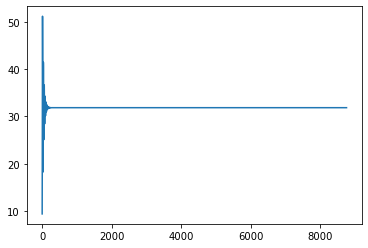

In [25]:
plt.plot(prediction2)

In [31]:
# aic_list = []
# mse_list = []


aic_array = np.ones((24,2))
mse_array = np.ones((24,2))
for i in range(24):
    for j in range(2):
        model = ARIMA(data_2021['CaseID'].values, order=(i+1,j+1,0))
        model_fit = model.fit()
    #     print(model_fit.summary())
#         aic_list.append(model_fit.aic)
#         mse_list.append(model_fit.mse)
        print(model_fit.aic)
        aic_array[i][j] = model_fit.aic
        mse_array[i][j] = model_fit.mse
        print((i+1, j+1))


# best_model = ARIMA(data_2021['CaseID'].values, order=(np.argmin(mse_list)+1,1,0))
# model_fit = model.fit()
# print(model_fit.summary())
# forecast = model_fit.predict(end=len(data_2022)-1)

78488.01822976553
(1, 1)
82511.56790486372
(1, 2)
78444.78118095003
(2, 1)
81440.3538711008
(2, 2)
78423.26772351036
(3, 1)
80788.34905875647
(3, 2)
78415.28152195444
(4, 1)
80375.08329994984
(4, 2)
78409.35880865299
(5, 1)
80079.50897817206
(5, 2)
78406.35710611002
(6, 1)
79871.4978001672
(6, 2)
78402.80014642612
(7, 1)
79749.72671186586
(7, 2)
78388.19469495006
(8, 1)
79671.25587295971
(8, 2)
78361.16366401187
(9, 1)
79632.81346650334
(9, 2)
78301.61870304665
(10, 1)
79607.47058993966
(10, 2)
78215.05142724572
(11, 1)
79594.16018812529
(11, 2)
78080.25212801197
(12, 1)
79580.66571768046
(12, 2)
77909.22632076283
(13, 1)
79547.07681183395
(13, 2)
77750.79127989578
(14, 1)
79493.06326061324
(14, 2)
77601.37672069753
(15, 1)
79433.9711292325
(15, 2)
77433.02924034231
(16, 1)
79336.22638802475
(16, 2)
77299.27434522036
(17, 1)
79251.80475059283
(17, 2)
77133.31324855813
(18, 1)
79206.02777891522
(18, 2)
76844.37517594101
(19, 1)
79162.03370612732
(19, 2)
76428.5233699929
(20, 1)
79137.58

In [87]:
# Since the mse_array is 24x2, need to divide by 2 and round in order to get proper index
order = np.round(np.argmin(mse_array)/2)+1
best_model = ARIMA(data_2021['CaseID'].values, order=(order,1,0))
model_fit = best_model.fit()
print(model_fit.summary())
forecast = model_fit.predict(end=len(data_2022)-1)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 8760
Model:                ARIMA(24, 1, 0)   Log Likelihood              -36938.945
Date:                Sun, 30 Apr 2023   AIC                          73927.891
Time:                        20:48:05   BIC                          74104.837
Sample:                             0   HQIC                         73988.183
                               - 8760                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4963      0.003   -195.030      0.000      -0.501      -0.491
ar.L2         -0.5529      0.004   -139.361      0.000      -0.561      -0.545
ar.L3         -0.5519      0.008    -66.715      0.0

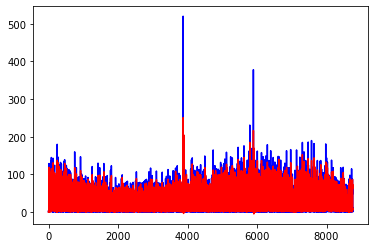

In [88]:
plt.plot(data_2021['CaseID'].values, c='b')
plt.plot(forecast, c='r')

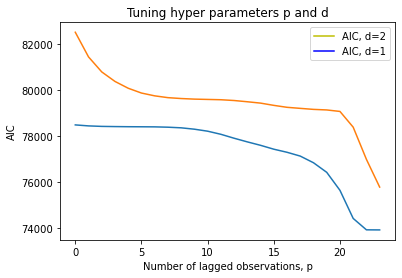

In [89]:
plt.plot(aic_array)
plt.plot([], c='y', label='AIC, d=2')
plt.plot([], c='b', label='AIC, d=1')
plt.xlabel("Number of lagged observations, p")
plt.ylabel("AIC")
plt.title("Tuning hyper parameters p and d")
plt.legend()
plt.show();

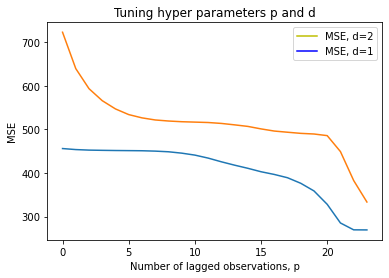

In [90]:
plt.plot(mse_array)
plt.plot([], c='y', label='MSE, d=2')
plt.plot([], c='b', label='MSE, d=1')
plt.xlabel("Number of lagged observations, p")
plt.ylabel("MSE")
plt.title("Tuning hyper parameters p and d")
plt.legend()
plt.show();

In [92]:
# I actually think 24,2,0 is better RMSE than 24,1,0 - investigate

rmse = np.sqrt(mean_squared_error(forecast, data_2022['CaseID']))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 18.367


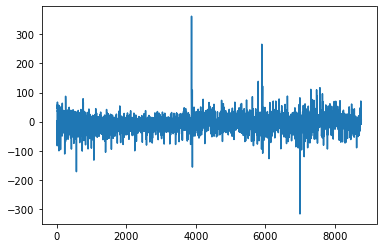

In [43]:
plt.plot(forecast-data_2022['CaseID'].values)
plt.show();

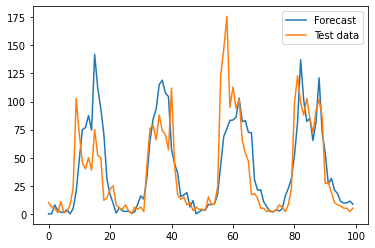

In [44]:
plt.plot(forecast[:100], label='Forecast')
plt.plot(data_2022['CaseID'].values[:100], label='Test data')
plt.legend();

<AxesSubplot:>

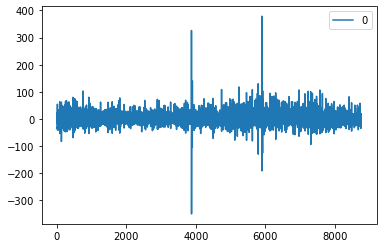

In [45]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()

<AxesSubplot:ylabel='Density'>

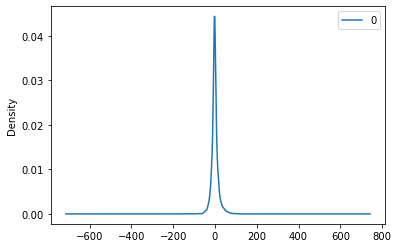

In [46]:
residuals.plot(kind='kde')

In [47]:
residuals.describe()

,0
count,8760.000000
mean,-0.005906
std,18.261543
min,-349.533293
25%,-7.183141
50%,-1.444335
75%,5.249089
max,378.380145


### Do it for all years

In [ ]:
models = []
forecasts = []
rmses = []
for i in range(2022-2008):
    print(i)
    train = full_hourly_count[full_hourly_count['Year']==(2008+i)]
    test = full_hourly_count[full_hourly_count['Year']==(2008+i+1)]
    model = ARIMA(train['CaseID'].values, order=(24,1,0))
    model_fit = model.fit()
#     print(model_fit.summary())
    forecast = model_fit.predict(end=len(test['CaseID'])-1)
    models.append(model)
    forecasts.append(forecast)
    rmse = np.sqrt(mean_squared_error(forecast, test['CaseID'].values))
    print('Test RMSE: %.3f' % rmse)
    rmses.append(rmse)
    
#     if i>1:
#         break

In [ ]:
# train = full_hourly_count[full_hourly_count['Year']==(2009)]
# test = full_hourly_count[full_hourly_count['Year']==(2010)]
# full_hourly_count[full_hourly_count['Year']==2009]['CaseID'].values
# model = ARIMA(train['CaseID'].values, order=(24,1,0))
# model_fit = model.fit()
# print(model_fit.summary())
# forecast = model_fit.predict(end=len(test['CaseID'])-1)
# rmse = np.sqrt(mean_squared_error(forecast, test['CaseID']))
# print('Test RMSE: %.3f' % rmse)

In [ ]:
plt.plot(rmses)
plt.xlabel("Model")
plt.ylabel("RMSE")
plt.title("RMSE values of each model")
plt.show();

In [ ]:
full_hourly_count[full_hourly_count['Year']==2009]['CaseID']

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,8))
for i in range(len(forecasts)):
    ax[0].plot(full_hourly_count[full_hourly_count['Year']==(2008+i+1)]['CaseID'].index, forecasts[i], c='b')
    ax[1].plot(full_hourly_count[full_hourly_count['Year']==(2008+i+1)]['CaseID'], \
            c='r')

fig.supxlabel("Hour")
fig.supylabel("Call volume")
fig.suptitle("ARIMA model (24,1,0)")
ax[0].set_ylim([0,550])
ax[0].set_title("Forecast call volume")
ax[1].set_ylim([0,550])
ax[1].set_title("Actual call volume")
plt.tight_layout();

In [ ]:
test = []
# for forecast in forecasts:
#     test.append(forecast.values)
#     print(forecast.shape)
#     print(forecast.values.reshape(1,-1)[0])
#     test.append(forecast.values.reshape(1,-1)[0])
    
# pd.vstack(forecasts)

plt.plot(pd.concat([forecast for forecast in forecasts], axis=0))

In [ ]:
plt.plot(rmses)

#### ARIMA (24,1,0)

In [125]:
model = ARIMA(train, order=(24,1,0))
model_fit = model.fit()
print(model_fit.summary())
forecast = model_fit.predict(end=len(test)-1)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:               103508
Model:                ARIMA(24, 1, 0)   Log Likelihood             -355923.110
Date:                Thu, 20 Apr 2023   AIC                         711896.221
Time:                        10:21:11   BIC                         712134.906
Sample:                             0   HQIC                        711968.544
                             - 103508                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5432      0.001   -653.976      0.000      -0.545      -0.542
ar.L2         -0.4553      0.002   -252.635      0.000      -0.459      -0.452
ar.L3         -0.4767      0.002   -229.737      0.0

In [144]:
rmse = np.sqrt(mean_squared_error(forecast, test))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 41.546


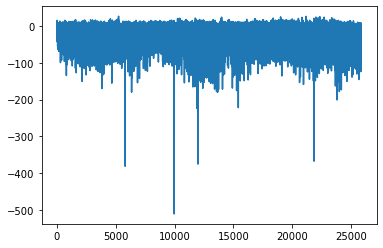

In [145]:
plt.plot(forecast-test.reshape(-1))
plt.show();

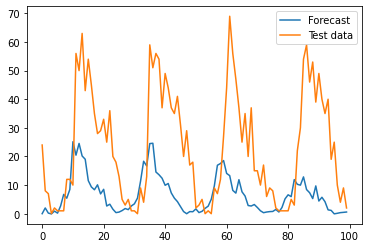

In [146]:
plt.plot(forecast[:100], label='Forecast')
plt.plot(test[:100], label='Test data')
plt.legend();

In [147]:
residuals = pd.DataFrame(model_fit.resid)

<AxesSubplot:>

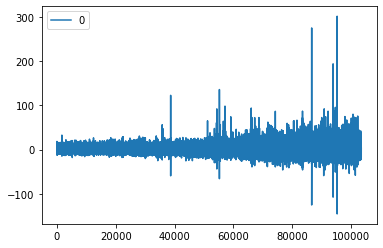

In [148]:
residuals.plot()

<AxesSubplot:ylabel='Density'>

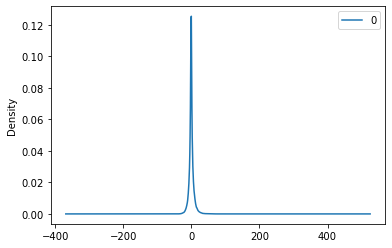

In [149]:
residuals.plot(kind='kde')

In [150]:
residuals.describe()

,0
count,103508.000000
mean,0.001919
std,7.535875
min,-145.405127
25%,-2.860669
50%,-0.485139
75%,2.168056
max,301.727692


#### ARIMA (8,1,0)

In [92]:
model = ARIMA(train, order=(8,1,0))
model_fit = model.fit()
print(model_fit.summary())
forecast = model_fit.predict(end=len(test)-1)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                89855
Model:                 ARIMA(8, 1, 0)   Log Likelihood             -339307.747
Date:                Wed, 19 Apr 2023   AIC                         678633.493
Time:                        11:42:23   BIC                         678718.147
Sample:                             0   HQIC                        678659.308
                              - 89855                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1081      0.001   -112.051      0.000      -0.110      -0.106
ar.L2          0.0275      0.002     12.536      0.000       0.023       0.032
ar.L3         -0.0160      0.003     -6.348      0.0

In [93]:
rmse = np.sqrt(mean_squared_error(forecast, test))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 43.259


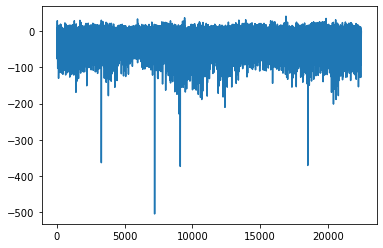

In [94]:
plt.plot(forecast-test)
plt.show();

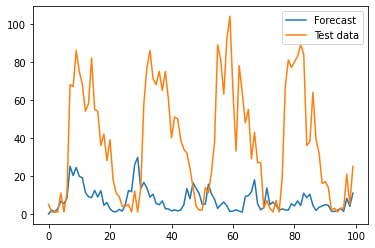

In [95]:
plt.plot(forecast[:100], label='Forecast')
plt.plot(test[:100], label='Test data')
plt.legend();

In [96]:
residuals = pd.DataFrame(model_fit.resid)

<AxesSubplot:>

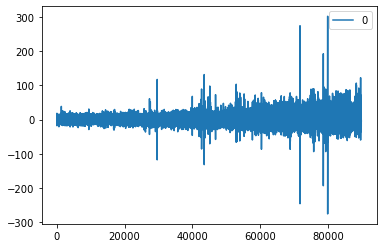

In [97]:
residuals.plot()

<AxesSubplot:ylabel='Density'>

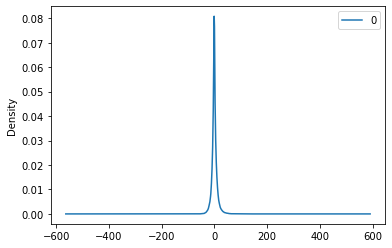

In [98]:
residuals.plot(kind='kde')

In [99]:
residuals.describe()

,0
count,89855.000000
mean,0.000318
std,10.562113
min,-275.193858
25%,-4.410721
50%,-0.618449
75%,3.646356
max,301.936924


#### Trying 1

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                89855
Model:                 ARIMA(1, 1, 0)   Log Likelihood             -339794.694
Date:                Wed, 19 Apr 2023   AIC                         679593.387
Time:                        11:43:16   BIC                         679612.199
Sample:                             0   HQIC                        679599.124
                              - 89855                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1043      0.001   -108.054      0.000      -0.106      -0.102
sigma2       112.7752      0.149    757.972      0.000     112.484     113.067
Ljung-Box (L1) (Q):                   1.12   Jarque-

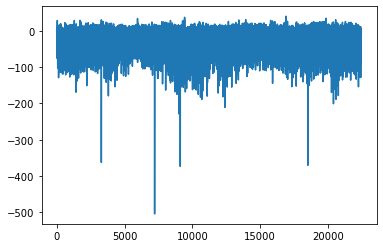

In [100]:
model = ARIMA(train, order=(1,1,0))
model_fit = model.fit()
print(model_fit.summary())
forecast = model_fit.predict(end=len(test)-1)
rmse = np.sqrt(mean_squared_error(forecast, test))
print('Test RMSE: %.3f' % rmse)
plt.plot(forecast-test)
plt.show();

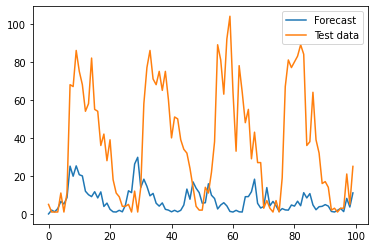

In [101]:
plt.plot(forecast[:100], label='Forecast')
plt.plot(test[:100], label='Test data')
plt.legend();

In [102]:
residuals = pd.DataFrame(model_fit.resid)

<AxesSubplot:>

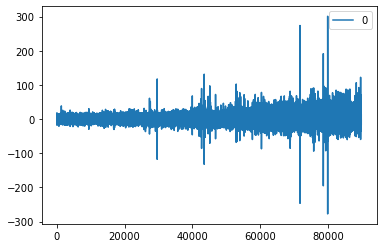

In [103]:
residuals.plot()

<AxesSubplot:ylabel='Density'>

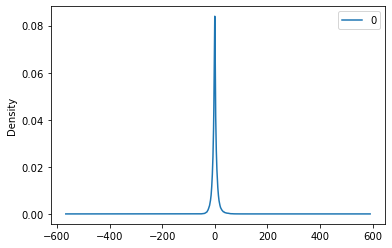

In [104]:
residuals.plot(kind='kde')

In [105]:
residuals.describe()

,0
count,89855.000000
mean,0.000174
std,10.619510
min,-277.411652
25%,-4.312756
50%,-0.293543
75%,3.582992
max,301.123464


### Trying auto-arima

In [108]:
model = auto_arima(train, start_p=1, start_q=1,
                           max_p=8, max_q=2, m=1,
                           seasonal=True,
                           d=0, trace=True,
                           error_action='warn',  
                           suppress_warnings=True, 
                           stepwise=True)
print(model.aic())

model.fit(train)

prediction1 = model.predict(n_periods=len(train))
prediction2 = model.predict(n_periods=len(test))

#plot the predictions for validation set
# plt.plot(time_train,train, label='train')
# plt.plot(time_test,test, label='test')
# plt.plot(time_train, prediction1, label='prediction1')
# plt.plot(time_test, prediction2, label='prediction2')
# plt.legend()
# plt.show()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=672781.870, Time=12.20 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=779863.233, Time=1.26 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=672818.180, Time=1.43 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=722518.095, Time=8.36 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=832321.319, Time=0.70 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=672526.585, Time=33.24 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=672771.065, Time=2.64 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=670130.373, Time=43.41 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=671564.356, Time=2.72 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=670090.195, Time=58.31 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=670954.866, Time=3.33 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=670022.290, Time=70.21 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=670633.464, Time=3.81 sec
 ARIMA(6,0,1)(0,0,0)[0] intercept   : AIC=669884.176, Time=89.41 sec

In [115]:
prediction1.shape

(89855,)

In [117]:
hourly_count[split:].index.shape

(22464,)

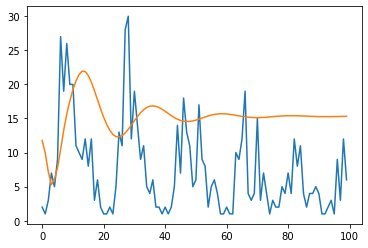

In [123]:
plt.plot(train[:100]);
plt.plot(prediction2[:100]);

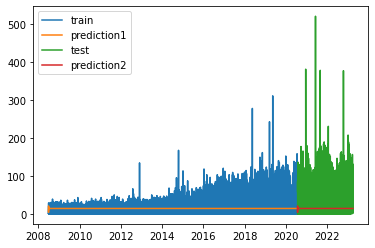

In [118]:
plt.plot(hourly_count[:split].index, train, label='train')
plt.plot(hourly_count[:split].index, prediction1, label='prediction1')
plt.plot(hourly_count[split:].index, test, label='test')
plt.plot(hourly_count[split:].index, prediction2, label='prediction2')
plt.legend()
plt.show()

### ARIMA TO-DOs
* Tune model, train/test RMSE
* Zip-code dummies
* Baseline - historical average for that date?

*Models to build:*
 * General volume
 * Garbage can overflowing
 * General cleaning
 * Bulky items
 
*Data Restrictions*
 * Use street cleaning category
 * Years: 2016-present (April 1st, 2023)

*Features to include:*
 * minute
 * day
 * hour
 * hour lags (hours 6-12)
 * ACS census tract data
 